<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/02_meerkat_UMAP_projections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


or "Mount Drive" in Files menu

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [ ]:
import os
import pandas as pd
import sys
import re
import json
#os.system('pip install "librosa==0.7.1"')
#import librosa
import librosa.display
import numpy as np
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gmean

### Setting constants

Setting project, input and output folders.

In [ ]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

### Installing AVGN

Cloning the AVGN_paper repository:

In [50]:
os.chdir(PROJECT_PATH)

if (not os.path.exists(PROJECT_PATH+'avgn_paper')):
  print("Cloning Repo")
  os.mkdir("avgn_paper")
  os.chdir("avgn_paper")
  os.sytem('git clone https://github.com/timsainb/avgn_paper.git')
else:
  print("Repo already present")
  os.chdir("avgn_paper")

os.system('python setup.py develop')

from importlib.machinery import SourceFileLoader
avgn = SourceFileLoader('avgnpaper/avgn', PROJECT_PATH+'avgn_paper/avgn/'+'utils/__init__.py').load_module()
import avgn

Repo already present


/content/drive/My Drive/meerkat/avgn_paper/avgn/utils/general.py:8: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



### Functions

In [ ]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

# UMAP projection

### Preparation

Choose dataset

In [33]:
#df = pd.read_pickle(DATA+'df_denoised') # full
#df = pd.read_pickle(DATA+'df_denoised_less_cols') # full
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')
#df['index_id'] = df.index#
df.shape

(9824, 35)

In [ ]:
df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n


Set spec_df to desired dataset

In [ ]:
# A) Full
spec_df = df
dftype='full'
dftype='balanced'

In [34]:
# B) Partial
#spec_df = df[df.call_lable == 'cc']
#dftype='cc'
#spec_df = df[df.call_lable != 'cc']
#dftype='non-cc'
spec_df = df[df.nonfocal_yn == 'n']
dftype='focal'
spec_df.shape

(6687, 35)

In [ ]:
# C) Analysis for individuals
pd.crosstab(index=df["indv"],
            columns="count") 

ind = 'VCVM001'
spec_df = df[df.indv == ind]
dftype='indv_'+ind

In [ ]:
df.head(10)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n
1601,ALARM,1:12:15.427,0:00.134,decimal,Cue,NaN,y,4335.427,0.134,4335.561,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,39,al,"[0.001953125, 0.00390625, 0.00390625, 0.003906...","[[-15.611752, -15.137981, -14.848536, -16.0097...","[[-230.35304, -216.11613, -199.99393, -189.522...","[[6.846904, 6.846904, 6.846904, 6.846904, 6.84...","[[-2.0848703, -2.0848703, -2.0848703, -2.08487...",n,"[[-16.879604, -17.779907, -17.648483, -17.0208...","[[-315.81796, -300.22, -276.8199, -251.16718, ...","[[9.787533, 9.787533, 9.787533, 9.787533, 9.78...","[[-3.4126015, -3.4126015, -3.4126015, -3.41260...","[[20.75996, 18.54282, 15.484863, 12.944105, 11...","[[32.35832, 27.98457, 24

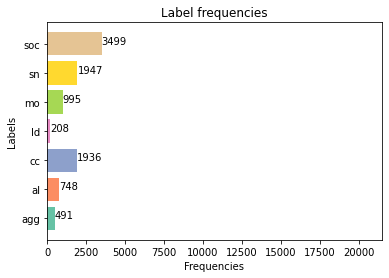

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,21500)
#plt.show()
plt.savefig(FIGURES+'final/'+'balanced_focal.png')

In [29]:
# D) Balanced classes
wo_cc_df = spec_df[spec_df.call_lable != 'cc']
cc_df = spec_df[spec_df.call_lable == 'cc']
cc_subset = cc_df.sample(frac=0.1, replace=False, random_state=1)
spec_df = pd.concat((wo_cc_df, cc_subset), ignore_index=False, axis=0)

dftype=dftype+'_balanced'

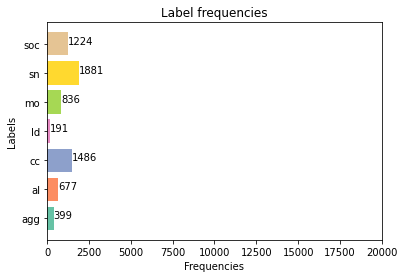

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,20000)

plt.show()

Completely balanced

In [35]:
# E) Completely balanced classes
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
class_size = np.min(labelcounts.call_lable.values)

subsets = []
for label, num in zip(labelcounts.index, labelcounts.call_lable.values):
  print(label, ":", num, ":", class_size/num)
  subsets.append(spec_df[spec_df.call_lable == label].sample(frac=(class_size/num), replace=False, random_state=1))

spec_df = pd.concat(subsets, axis=0)
dftype = 'complete_balanced'
#pd.DataFrame(spec_df['call_lable'].value_counts())

sn : 1881 : 0.10154173312068049
cc : 1479 : 0.12914131169709264
soc : 1224 : 0.15604575163398693
mo : 836 : 0.2284688995215311
al : 677 : 0.2821270310192024
agg : 399 : 0.47869674185463656
ld : 191 : 1.0


## Divide certain and uncertain

In [ ]:
os.listdir(DATA)

In [ ]:
certain_df = spec_df[spec_df.certain_yn == 'y']
uncertain_df = spec_df[spec_df.certain_yn == 'n']

In [ ]:
certain_df.shape

(5653, 24)

In [ ]:
uncertain_df.shape

(130, 24)

In [ ]:
df.columns

Index(['Name', 'Start', 'Duration', 'Time Format', 'Type', 'Description',
       'call_yn', 'start_s', 'duration_s', 'stop_s', 'date', 'samplerate_hz',
       'indv', 'original_wav', 'bout_number', 'call_lable', 'raw_audio',
       'spectrograms', 'mfccs', 'mfcc_deltas', 'mfcc_deltadeltas',
       'soundfoc_yn', 'stretched_spectrograms', 'stretched_mfccs',
       'stretched_mfcc_deltas', 'stretched_mfcc_deltadeltas',
       'denoised_spectrograms', 'denoised_stretched_spectrograms',
       'denoised_mfccs', 'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

## Redo stretched - only once here

In [ ]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
#SR = 48000
#SR = 22050 # for padded
FMAX = 4000
MAX_DURATION = 0.5

In [ ]:
def generate_stretched_mel_spectrogram_NEW(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION
    #stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    #D = np.abs(D)**2
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = np.abs(D_stretched)**2

    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(spectro, ref=np.max) # power to db transform

    return s


spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                            row['samplerate_hz'], 
                                                                            row['duration_s'],
                                                                            N_MELS,
                                                                            WINDOW,
                                                                            FFT_WIN,
                                                                            FFT_HOP),
                        axis=1)

df['stretched_new'] = spectrograms
df['stretched_denoised_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_new']]

In [ ]:
specs = df.stretched_denoised_new.values

## Choose features

Set specs to desired data and declare method with String. We can use melspectrograms (A) or MFCCs (B). 

In [ ]:
spec_df.columns

Index(['duration_s', 'samplerate_hz', 'indv', 'original_wav', 'bout_number',
       'call_lable', 'raw_audio', 'spectrograms', 'mfccs', 'mfcc_deltas',
       'mfcc_deltadeltas', 'soundfoc_yn', 'stretched_spectrograms',
       'stretched_mfccs', 'stretched_mfcc_deltas',
       'stretched_mfcc_deltadeltas', 'denoised_spectrograms',
       'denoised_stretched_spectrograms', 'denoised_mfccs',
       'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas'],
      dtype='object')

In [ ]:
# 0.1) Using raw audio
specs = spec_df.raw_audio.values # now 2D arrays n_mels+time_frames(varying)
method = 'raw_audio'

maxlen= np.max([spec.shape[0] for spec in specs])
padded_specs = [np.pad(spec, (0,maxlen-spec.shape[0]), 'constant') for spec in specs]
specs_arr = np.asarray(padded_specs)

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(specs_arr))

In [ ]:
# A.1) Using mel spectrograms:
specs = spec_df.spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'melspectro'

In [ ]:
# A.2) Using stretched mel spectrograms:
specs = spec_df.stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'stretched_melspectro'

In [ ]:
# A.3) Using denoised stretched mel spectrograms:
specs = spec_df.denoised_stretched_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_stretched_melspectro'

In [36]:
# A.3) Using denoised mel spectrograms:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'

In [ ]:
lengths = []

for spec in specs:
  lengths.append(spec.shape[1])

np.mean(np.asarray(lengths))

40.23762524300882

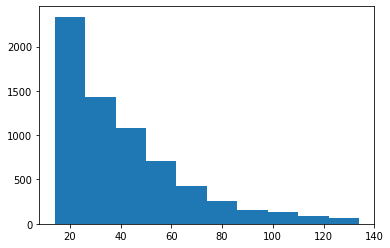

In [ ]:
n, bins, patches = plt.hist(lengths)

In [ ]:
# B.1) Using MFCCs:
specs = spec_df.mfccs.values
method='mfcc'

In [ ]:
# B.2) Using stretched MFCCs:
specs = spec_df.stretched_mfccs.values
method='stretched_mfcc'

In [ ]:
# B.3) Using stretched denoised MFCCs:
specs = spec_df.denoised_stretched_mfccs.values
method='denoised_stretched_mfcc'

In [ ]:
# B.4) Using denoised MFCCs:
specs = spec_df.denoised_mfccs.values
method='denoised_mfcc'

In [ ]:
data.shape

(6687, 134)

Pad with zeros and normalize

In [37]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

In [38]:
data.shape

(1337, 5320)

**Optional: Include deltas in feature vector**

Can choose deltas or delta-deltas

In [ ]:
# B.3) Using stretched denoised MFCCs:
deltas = spec_df.denoised_stretched_mfccs.values
method=method+'_mfcc'

In [ ]:
# A.1) MFCC Deltas
deltas = spec_df.mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.2) MFCC Deltas stretched
deltas = spec_df.stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.3) MFCC Deltas stretched denoised
deltas = spec_df.denoised_stretched_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# A.4) MFCC Deltas denoised
deltas = spec_df.denoised_mfcc_deltas.values
method =method+'_delta'

In [ ]:
# B.1) MFCC Deltadeltas
deltas = spec_df.mfcc_deltadeltas.values
method =method+'_deltadelta'

Or duration

In [ ]:
from scipy.stats import zscore

In [ ]:
dur = zscore(spec_df.duration_s.values)
data = pd.DataFrame(data)
data['dur'] = dur
data = np.asarray(data)

Pad and normalize

In [ ]:
maxlen= np.max([delta.shape[1] for delta in deltas])
flattened_deltas = [pad_spectro(delta, maxlen).flatten() for delta in deltas]
deltas_arr = np.asarray(flattened_deltas)

delta_data = StandardScaler().fit_transform(pd.DataFrame(deltas_arr))
#delta_data = pd.DataFrame(deltas_arr)

Concatenate:

In [ ]:
data = np.concatenate((data, delta_data), axis=1)

## Running UMAP

In [ ]:
n_neighbors = 15
n_components

In [ ]:
reducer = umap.UMAP(low_memory=True, n_neighbors = 20, n_components = 3) #  low values of min_dist will result in clumpier embeddings
reducer = umap.UMAP(low_memory=True, n_components = 3, min_dist=0) 

In [ ]:
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# Supervised!
call_labels = np.asarray(pd.factorize(spec_df.call_lable.values))
call_labels = call_labels[0]

reducer = umap.UMAP(low_memory=True,n_components = 10, target_weight=0.2)
embedding = reducer.fit_transform(data,y=call_labels) # supervised dim reduction

In [39]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)

In [40]:
embedding = reducer.fit_transform(data)
embedding.shape # (27244, 2) all

(1337, 5)

### Save embedding



In [ ]:
method = method+'_focal'
print(method)

denoised_melspectro_focal


In [ ]:
datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_'+method+'_'+dftype

'2020-10-20_embedding_denoised_melspectro_focal_focal'

In [ ]:
spec_df.head(3)

,Name,Start,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn
1584,CC,1:00:15.043,y,3615.043,0.083,3615.126,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,4,cc,"[-0.0078125, 0.00390625, -0.009765625, -0.0058...","[[-5.00301, -5.2624416, -4.9811325, -4.3282547...","[[-147.81346, -151.1712, -158.07703, -159.4540...","[[0.71534294, 0.71534294, 0.71534294, 0.715342...",n,"[[-10.160519, -8.448254, -8.041008, -9.920231,...","[[-299.12057, -277.68695, -226.69044, -194.237...","[[12.585518, 12.585518, 12.585518, 12.585518, ...","[[17.339697, 18.042007, 19.765783, 22.686983, ...","[[38.11735, 37.514843, 31.096657, 21.984482, 1...","[[-6.505764, -3.7809324, -1.5637956, 11.405321...","[[6.215486, 13.009188, 20.837872, 7.5455985, -...","[[2.7452314, 2.7452314, 2.7452314, 2.7452314, ...","[[-0.36869705, -0.36869705, -0.36869705, -0.36...",y
1585,CC,1:00:35.627,y,3635.627,0.191,3635.818,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,5,cc,"[-0.021484375, -0.01953125, -0.015625, -0.0253...","[[-2.0994568, -2.1183338, -2.4481869, -2.52930...","[[-182.17676, -172.59605, -161.6688, -155.9510...","[[4.782921, 4.782921, 4.782921, 4.782921, 4.78...",n,"[[-3.6559372, -4.0523834, -3.5657997, -3.85589...","[[-283.74167, -262.43655, -224.60722, -199.279...","[[10.116256, 10.116256, 10.116256, 10.116256, ...","[[26.603214, 23.59336, 22.140139, 22.74288, 25...","[[39.65626, 34.43138, 31.346516, 26.531246, 24...","[[-0.6451429, -9.981032, -6.158573, 3.8842514,...","[[-9.811282, -19.043835, -3.8023443, -7.094287...","[[-0.09826555, -0.09826555, -0.09826555, -0.09...","[[0.5400675, 0.5400675, 0.5400675, 0.5400675, ...",y
1586,CC,1:01:10.577,y,3670.577,0.145,3670.722,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,8,cc,"[-0.0390625, -0.037109375, -0.041015625, -0.03...","[[-9.536743e-07, -1.0446749, -4.06676, -8.0304...","[[-198.96457, -183.90721, -165.92061, -154.107...","[[6.3840265, 6.3840265, 6.3840265, 6.3840265, ...",n,"[[-8.488825, -6.3999805, -2.294176, 1.9073486e...","[[-289.95355, -267.5201, -246.2507, -229.30716...","[[11.541756, 11.541756, 11.541756, 11.541756, ...","[[31.281498, 28.889343, 23.64156, 17.571968, 1...","[[39.643806, 35.62033, 37.063484, 35.356842, 3...","[[-1.1229907, 5.4121504, 9.322178, 7.8163314, ...","[[14.463937, -1.7603488, 2.6689968, -5.6908846...","[[0.36921495, 0.36921495, 0.36921495, 0.369214...","[[-0.6972977, -0.6972977, -0.6972977, -0.69729...",y


In [ ]:
embedding = pd.DataFrame(embedding)
embedding['index_id'] = spec_df['index_id']
#embedding['index_id'] = spec_df.index

embedding_filename = datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_'+method+'_'+dftype
embedding_filename = datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'embedding_denoised_melspectro_balanced_no_z'

print(DATA+embedding_filename)
embedding.to_pickle(DATA+embedding_filename)

/content/drive/My Drive/meerkat/data/2020-10-23_embedding_denoised_melspectro_balanced_no_z


In [ ]:
os.listdir(DATA)

In [ ]:
# NOT z-Transformed
#embedding_filename='2020-10-14_embedding_denoised_melspectro_full'
#embedding_filename = '2020-10-14_embedding_denoised_melspectro_balanced'
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'



# z-transformed
#embedding_filename = '2020-10-14_embedding_no_z_denoised_melspectro_full',
#embedding_filename = '2020-10-23_embedding_denoised_melspectro_balanced_no_z'
#embedding_filename = '2020-10-20_embedding_denoised_melspectro_focal_focal' # I GUESS

In [ ]:
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding)[:,0:5]

PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(data)
embedding = pca.transform(data)

## Visualization

### 3D Plots

#### Matplotlib animation

In [ ]:
umap_df = spec_df
#embedding = np.asarray(embedding)

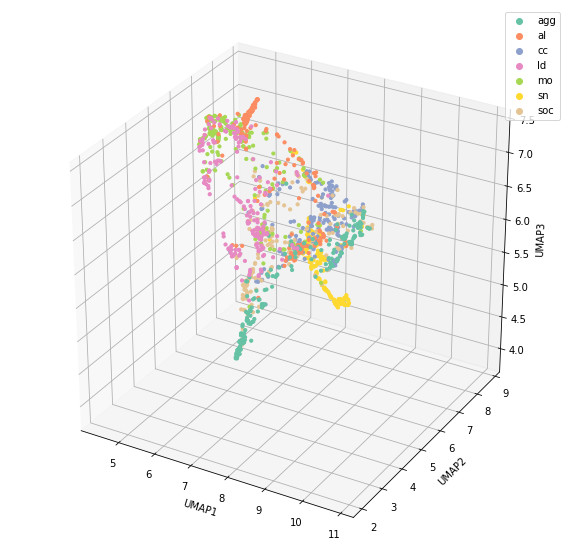

In [48]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               zs = embedding[:,2],
               #zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
#ax.set_zlabel('Duration')
ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

#plt.show()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_denoised_melspectro_focal_completely_balanced')

Animation:

In [49]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_denoised_melspectro_focal_completely_balanced.gif', dpi=80, writer='pillow', fps=12)
#anim.save(FIGURES+'2020-10-23-melpectro_denoised_UMAP3_not_z.gif', dpi=80, writer='pillow', fps=12)

#anim.save(FIGURES+'melpectro_denoised_UMAP3.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

#### Plotly

In [ ]:
scaler = MinMaxScaler(feature_range=(0,10))
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

In [ ]:
spec_df=df
spec_df.shape
umap_df = spec_df

In [ ]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = umap_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = umap_df.indv.values+" "+umap_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### 2D plots

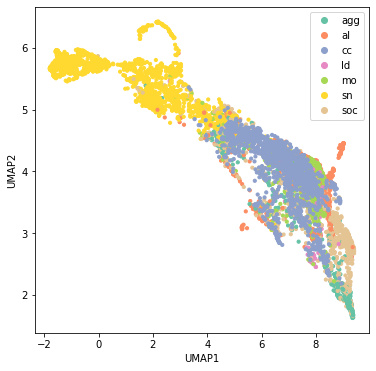

In [ ]:
# 2D plot

fig = plt.figure(figsize=(6,6))
scat_labels = umap_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

plt.scatter(embedding[:,0], embedding[:,1], alpha=1,
            s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
plt.legend(scatters, labeltypes, numpoints = 1)
plt.show()

### AVGN Plots

In [52]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [53]:
z  = list(embedding[:,0:2])
z = np.vstack(z)

# Use spectrogram examples
#specs = spec_df.spectrograms.values
#specs = spec_df.stretched_spectrograms.values
specs = spec_df.denoised_stretched_spectrograms.values

#### By individual

/content/drive/My Drive/meerkat/figures/2020-09-13_denoised_stretched_melspectro_focal_ind


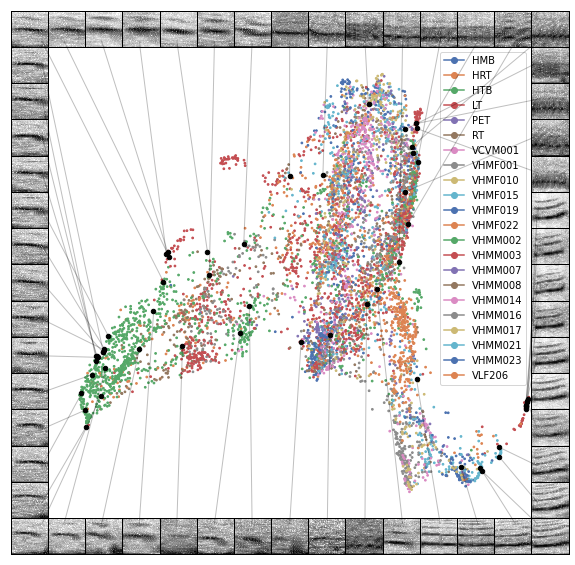

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.indv.values,
        'alpha':1.0,
        's': 3,
        #"color_palette": 'Set2',
        "color_palette": 'deep',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_ind'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By label

/content/drive/My Drive/meerkat/figures/2020-10-26_completely_balanced_call


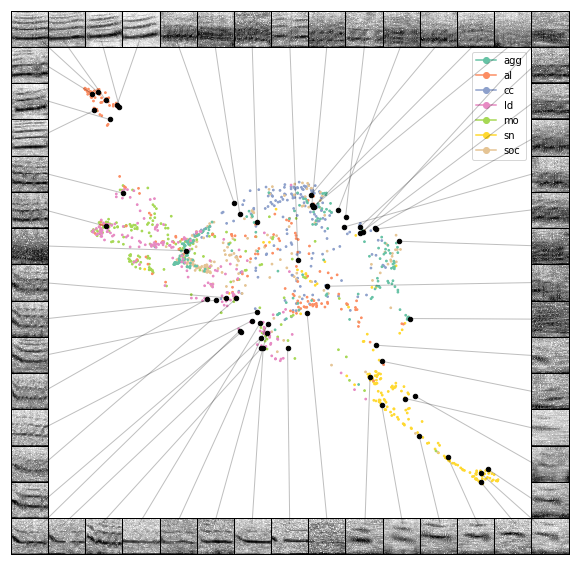

In [54]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.call_lable.values,
        #'labels': np.repeat([1], spec_df.shape[0]),
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_call'
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_completely_balanced_call'
save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

#### By recording type (focal or nonfocal)

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': spec_df.soundfoc_yn.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plot_name = FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+method+'_'+dftype+'_soundfoc'
#save_fig(plot_name, dpi=300, save_jpg=True)
print(plot_name)

# UMAP with random distance matrix

To see how embedding scores 

In [ ]:
random_distmat = np.random.rand(data.shape[0],data.shape[0])

In [ ]:
random_distmat.shape

(9824, 9824)

In [ ]:
for i in range(random_distmat.shape[0]):
  for j in range(i,random_distmat.shape[0]):
      random_distmat[i,j] = random_distmat[j,i]

for i in range(random_distmat.shape[0]):
  random_distmat[i,i] = 0

In [ ]:
reducer = umap.UMAP(low_memory=True, metric='precomputed', min_dist=0, n_components=10)
embedding = reducer.fit_transform(random_distmat)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



# Embedding evaluation

Evaluate the embedding. Since it's unsupervised, this is really difficult. Best would be to have a measure of dissimilarity that we trust but there's no obvious choice. VGG Net similarity would be an option.

Thus, for now, evaluate it based on the labelled calls.

In [ ]:
# Add duration
embedding_df = pd.DataFrame(embedding)
embedding_df['duration'] = umap_df.duration_s.values

embedding = np.asarray(embedding_df)
embedding_df.head(3)

#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')
calltypes = sorted(list(set(umap_df['call_lable'])))

#embedding_vars = ['UMAP1', 'UMAP2', 'duration_s'] 
#embedding = np.asarray(df[embedding_vars])
labels = df.call_lable.values

# Normalize
scaler = MinMaxScaler(feature_range=(0,10))
scaler.fit(embedding)
embedding = scaler.transform(embedding)
metric_type = 'euclidean'

In [41]:
umap_df = spec_df
print(umap_df.shape)
print(embedding.shape)

(1337, 35)
(1337, 5)


In [42]:
#umap_df = spec_df
calltypes = sorted(list(set(umap_df['call_lable'])))
labels = umap_df.call_lable.values

## Find nearest neighbors

In [ ]:
embedding = data

In [43]:
k=5

# Find k nearest neighbors
#nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
#distances, indices = nbrs.kneighbors(embedding)

nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [44]:
nn_stats_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts

## Calculate metrics

In [45]:
# Overall frequencies
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  sub_emb = embedding[labels==calltype,:]
  overall[i] = sub_emb.shape[0] 

overall = (overall/np.sum(overall))*100


stats_tab = np.zeros((len(calltypes),len(calltypes)))
stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

for i, calltype in enumerate(calltypes):
  stats = nn_stats_dict[calltype]
  stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
  stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

stats_tab = pd.DataFrame(stats_tab)
stats_tab_norm = pd.DataFrame(stats_tab_norm)

stats_tab.loc[len(stats_tab)] = overall
#stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

stats_tab.columns = calltypes
stats_tab.index = calltypes+['overall']

stats_tab_norm.columns = calltypes
stats_tab_norm.index = calltypes
x = stats_tab_norm.replace(0,0.0001)
stats_tab_norm = np.log2(x)

In [ ]:
stats_tab_norm

,agg,al,cc,ld,mo,sn,soc
agg,2.987304,-2.376382,-0.689457,-3.699852,-3.003769,-2.972253,0.262660
al,-2.845867,3.045437,-1.240189,0.292745,0.519528,-2.467676,-2.265712
cc,-0.703957,-1.459502,1.504386,-0.701856,-1.844492,-2.945732,-0.174467
ld,-4.114890,0.231991,-0.219705,2.758456,1.584955,-1.733114,-0.620111
mo,-2.913571,0.445947,-1.628910,1.647497,2.561735,-1.506631,-1.955063
sn,-2.678522,-2.404482,-2.496343,-1.420524,-1.375568,2.063014,-2.393275
soc,0.233485,-2.368227,-0.143631,-0.700110,-2.032890,-2.762418,0.935325


In [ ]:
import seaborn as sns

In [46]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.0361921348154213
Log final metric (unweighted) gmean: 2.0202070829601704
Abs final metric (unweighted): 59.63


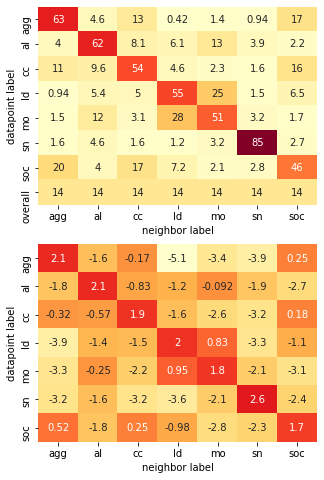

In [47]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)
#plt.subplot(1, 3, 2)
#ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
#plt.xlabel("neighbor label")
#plt.ylabel("datapoint label")
#plt.show()

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
#plt.savefig(FIGURES+embedding_filename+'_eval5D.png')
#plt.savefig(FIGURES+'denoised_balanced_focal_original_space_eval.png')
#print(FIGURES+embedding_filename+'_eval3D.png')

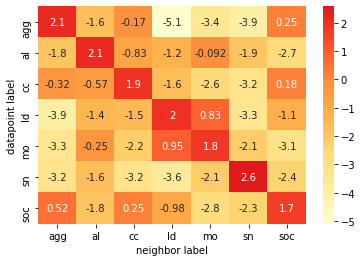

In [55]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()
# log2(probability of neighbor label within k nearest neighbors of datapoint / overallll probability of neighbor label)

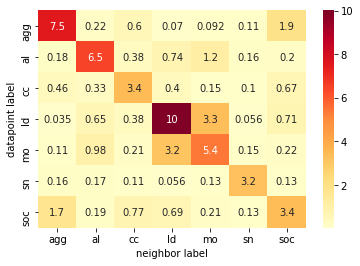

In [ ]:
# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)

ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd',cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

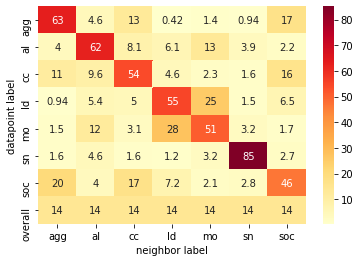

In [56]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

Calculate percentage of "correct" neighbors. Overlooking the fact that we don't even desire to always have the same calltype in the ten nearest datapoints, but alright.

In [ ]:
np.diagonal(stats_tab.iloc[:-1,])

array([29.57230143, 58.85026738, 53.40392562, 11.68269231, 54.75376884,
       88.88546482, 65.33866819])

## k curve

In [ ]:
metrics_dict = {}

In [ ]:
encoding = 'spectrogram'
method = 'original'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']


specs = spec_df.denoised_spectrograms.values
labels = spec_df.call_lable.values


maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
embedding=data


In [ ]:
# OR FOCAL:
encoding = 'spectrogram'
method = 'embedded'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

labels = spec_df.call_lable.values
embedding = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_focal')
embedding = np.asarray(embedding)[:,0:5]


In [ ]:
# OR BALANCED:
encoding = 'spectrogram'
method = 'embedded'

df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df


labels = spec_df.call_lable.values
embedding = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_balanced')
embedding = np.asarray(embedding)[:,0:5]

In [ ]:
ks = [1,3,5,8,10,15,20,30,40]

metrics_tab = np.zeros((len(ks),4))
for k_num,k in enumerate(ks):
#k=1

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  nn_stats_dict = {}
  calltypes = sorted(list(set(labels)))
  labels = np.asarray(labels)

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts

  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    sub_emb = embedding[labels==calltype,:]
    overall[i] = sub_emb.shape[0] 

  overall = (overall/np.sum(overall))*100

  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  metrics_tab[k_num,0] = np.mean(np.diagonal(stats_tab_norm))
  metrics_tab[k_num,1] = np.average(np.diagonal(stats_tab_norm), weights=overall)
  metrics_tab[k_num,2] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  metrics_tab[k_num,3] = np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)

metrics_dict[encoding+'_'+method] = metrics_tab

In [ ]:
metrics_dict.keys()

dict_keys(['spectrogram_original', 'spectrogram_embedded'])

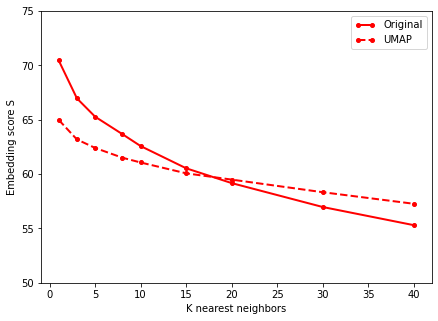

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=4, label="Original")
plt.plot(ks, metrics_dict['spectrogram_embedded'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="UMAP")
plt.ylabel("Embedding score S")
plt.xlabel("K nearest neighbors")
plt.legend(numpoints=2)
plt.ylim(50,75)

plt.savefig(FIGURES+'spectrogram_balanced_focal_ks.png')

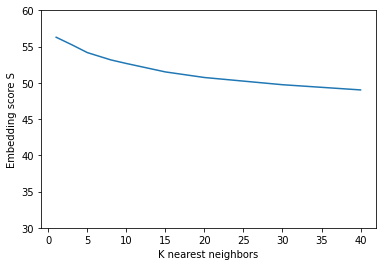

In [ ]:
#fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_embedded'][:,2])
plt.ylabel("Embedding score S")
plt.xlabel("K nearest neighbors")
#plt.axvline(x=5, color="black", linestyle='--')
plt.ylim(30,60)
#plt.show()
plt.savefig(FIGURES+'opti_UMAP_ks.png')

# Correlation between original and embedded space

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
!pip install scikit-bio

In [ ]:
from skbio.stats.distance import mantel

In [ ]:
# balanced, focal-only dataset
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

In [ ]:
# embedding
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = embedding[:,0:5]

In [ ]:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

In [ ]:
distmat = squareform(pdist(data, metric='euclidean'))

In [ ]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [ ]:
print(distmat.shape)
print(distmat_embedded.shape)

(6687, 6687)
(6687, 6687)


In [ ]:
x = mantel(distmat, distmat_embedded, method='spearman')

In [ ]:
print(round(coeff, 4))
print(round(p_value,4))

# Embedding evaluation 2: same vs. different group distances

Evaluate an embedding based on the ratio of distance of a point to all other points of the same label vs. to all other points of other labels

In [ ]:
nn_stats_dict

{'agg': array([[0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 1., ..., 0., 0., 2.],
        [0., 0., 1., ..., 0., 0., 2.],
        ...,
        [3., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 2.],
        [3., 0., 0., ..., 0., 0., 0.]]),
 'al': array([[0., 2., 1., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 2.]]),
 'cc': array([[0., 0., 2., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 2., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 2.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 0., 0., 3.]]),
 'ld': array([[0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0., ..., 2., 1., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 2., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0.,

In [ ]:
k=3

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
maj_vote_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  n_calls = len(call_indices)
  point_label = calltype
  point_in_majority = 0
  no_majority = 0

  for ind in call_indices:
    nearest_neighbors = indices[ind]
    neighbor_labels = [labels[x] for x in nearest_neighbors]
    most_frequent = Counter(neighbor_labels).most_common(1)

    # is there a majority?
    if most_frequent[0][1] > 1:
      majority_vote = most_frequent[0][0]
      if majority_vote == point_label:
        point_in_majority += 1
    else:
      no_majority += 1

  maj_vote_dict[calltype] = [point_in_majority, no_majority, n_calls]
  # normalize to random probability to have majority vote of same calltype!
  # What is the probability of having >k/2 

  # lead: 0.2%
  # p(4 leads in 8 pulls) = (0.2)^4*(1-0.2)^4 * all possible combinations of arranging 8 items

maj_vote_dict

{'agg': [203, 56, 491],
 'al': [475, 76, 748],
 'cc': [1114, 195, 1936],
 'ld': [19, 38, 208],
 'mo': [636, 144, 995],
 'sn': [1610, 102, 1947],
 'soc': [2508, 291, 3499]}

In [ ]:
calltype = 'sn'
point_label = calltype
call_indices = np.asarray(np.where(labels==calltype))[0]
len(call_indices)
ind = call_indices[10]
nearest_neighbors = indices[ind]
neighbor_labels = [labels[x] for x in nearest_neighbors]
neighbor_labels

['sn', 'sn', 'sn']

In [ ]:
Counter(neighbor_labels).most_common(1)

[('sn', 3)]

In [ ]:
#from collections import Counter

l = ['dog', 'monkey', 'jimbo']
most_frequent = Counter(l).most_common(1)



In [ ]:
most_frequent[0][0]

'dog'

In [ ]:
neighbor_labels

['soc', 'soc', 'soc']

# Embedding evaluation 3: VGG Net similarity of nearest neighbors

Use VGG Net predicted image similarity of spectrograms as ground truth (This will not always be a good idea). 

# Embedding Optimization

Grid search with different parameters to find the best embedding.
Parameters: 
* UMAP parameters (min_dist, spread, metric)
* inputs (stretched, denoised, MFCC etc)
* adding duration as dimension or not

In [ ]:
def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [ ]:
k=5
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean', 'cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'

labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  overall[i] = sum(labels==calltype)
overall = (overall/np.sum(overall))*100


f = open("UMAP_optimization_Oct2020.txt","w+")
header = ['k',
          'min_dist',
          'spread',
          'metric',
          'n_components',
          'input_var',
          'add_duration',
          'normalize',
          'mean_log_unweighted', 
          'mean_log_weighted',
          'mean_abs_unweighted',
          'mean_abs_weighted']
header = header+calltypes+calltypes
header_str = ";".join(header)
f.write(header_str+"\r\n")
f.close()

In [ ]:
%pwd

'/content/drive/My Drive/meerkat'

In [ ]:
# Example with one:
k=10
MIN_DIST = 0
SPREAD = 1
METRIC = 'euclidean'
N_COMPONENTS = 2
INPUT_VAR = 'denoised_spectrograms'
ADD_DURATION = True
NORMALIZE = False


# Open file
f = open("UMAP_optimization.txt","w+")

# Select input data
print('\rPreparing data...',end='')
specs = np.asarray(spec_df[INPUT_VAR])
method = INPUT_VAR

# Flatten and pad with zeros
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

if NORMALIZE:
  data = StandardScaler().fit_transform(pd.DataFrame(data))

# Run UMAP
print('\rRunning UMAP...',end='')
reducer = umap.UMAP(low_memory=True, 
                    n_components = N_COMPONENTS, 
                    metric = METRIC, 
                    min_dist = MIN_DIST,
                    spread = SPREAD)
embedding = reducer.fit_transform(data)

# Get nearest neighbors
print('\rGetting nearest neighbors...',end='')
indices, distances = get_knn(k,embedding)

# count neighbor labels
print('\rCounting neighbor labels...',end='')
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

# Make statstabs
print('\rMaking statstabs...',end='')
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

# Write results to file
print('\rWrite to file...',end='')
f = open("UMAP_optimization.txt","w+")

params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
params_str = ';'.join([str(x) for x in params])

# Metrics
mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                           np.average(np.diagonal(stats_tab_norm), weights=overall),
                           np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                           np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
all_metrics = np.concatenate((mean_metrics,
                np.diagonal(stats_tab_norm), 
                np.diagonal(stats_tab)))

all_metrics_str = np.char.mod('%f', all_metrics)
all_metrics_str = ";".join(all_metrics_str)

all_results_str = params_str+";"+all_metrics_str
f.write(all_results_str+"\r\n")
f.close()

print('\rDone!',end='')

Done!

Grid search:

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'

labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean']
n_components_list = [2,10]

input_vars = ['spectrograms',  'stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 
          'mfccs','stretched_mfccs','denoised_mfccs', 'denoised_stretched_mfccs']

normalize_list = [True, False]

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['cosine']
n_components_list = [2,10]

input_vars = ['spectrograms',  'stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 
              'mfccs','stretched_mfccs','denoised_mfccs', 'denoised_stretched_mfccs']

normalize_list = [True, False]

In [ ]:
for input_var in input_vars:
  for normalize in normalize_list:
    for min_dist in min_dists:
      for metric in metrics:
        for spread in spreads:
          for n_components in n_components_list:
              print(input_var, normalize, min_dist, metric, spread, n_components)

              # Select input data
              print('\rPreparing data...',end='')
              specs = np.asarray(spec_df[input_var])

              # Flatten and pad with zeros
              maxlen= np.max([spec.shape[1] for spec in specs])
              flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
              data = np.asarray(flattened_specs)

              if normalize:
                data = StandardScaler().fit_transform(pd.DataFrame(data))

              # Run UMAP
              print('\rRunning UMAP...',end='')
              reducer = umap.UMAP(low_memory=True, 
                                  n_components = n_components, 
                                  metric = metric, 
                                  min_dist = min_dist,
                                  spread = spread)
              embedding = reducer.fit_transform(data)

              add_duration = False

              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              f = open("UMAP_optimization_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n')  

              add_duration = True
              embedding_df = pd.DataFrame(embedding)
              embedding_df['duration'] = spec_df.duration_s.values
              embedding = np.asarray(embedding_df)     


              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              f = open("UMAP_optimization_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n') 



spectrograms True 0.1 cosine 1 10
Done!
Done!
spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms False 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
mfccs True 0.1 cosine 1 10
Done!
Done!
mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_mfccs False 0.1 cosine 1 10
Done!
Done!
stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
stretched_mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 1 10
Done!
Done!


## Analyzing grid search results

In [ ]:
k=5
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean', 'cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
import scipy.stats as stats

opti_table_all = pd.read_csv(PROJECT_PATH+'UMAP_optimization.txt', sep=";", header=0)
opti_table = opti_table_all
#opti_table = opti_table_all.loc[opti_table_all['metric']=='euclidean']

#opti_table = opti_table[opti_table.input_var.isin(['spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 'stretched_spectrograms'])]
var_of_interest = 'mean_abs_unweighted'

In [ ]:
opti_table = opti_table.iloc[:,0:12]

In [ ]:
# use only euclidean
opti_table = opti_table.loc[opti_table_all['metric']=='euclidean']

In [ ]:
opti_table

,k,min_dist,spread,metric,n_components,input_var,add_duration,normalize,mean_log_unweighted,mean_log_weighted,mean_abs_unweighted,mean_abs_weighted
0,10,0.0,1,euclidean,2,spectrograms,False,True,1.632390,1.391078,40.714325,54.273208
1,10,0.0,1,euclidean,2,spectrograms,True,True,1.580421,1.375525,40.177966,54.035016
2,10,0.0,1,euclidean,10,spectrograms,False,True,1.662180,1.423559,41.757356,55.358306
3,10,0.0,1,euclidean,10,spectrograms,True,True,1.662421,1.423717,41.743966,55.380700
4,10,0.0,5,euclidean,2,spectrograms,False,True,1.653599,1.408534,41.302052,54.873779
...,...,...,...,...,...,...,...,...,...,...,...,...
283,10,0.1,1,cosine,10,stretched_mfccs,True,False,2.087550,1.670250,50.826221,63.002850
284,10,0.1,1,cosine,10,denoised_stretched_mfccs,False,True,2.218893,1.659330,52.278828,61.279520
285,10,0.1,1,cosine,10,denoised_stretched_mfccs,True,True,2.374023,1.794684,57.219919,67.192590
286,10,0.1,1,cosine,10,denoised_stretched_mfccs,False,False,2.194096,1.672790,52.534065,62.192590


In [ ]:
opti_table['input_var'].value_counts()

spectrograms                       36
denoised_spectrograms              36
stretched_spectrograms             36
denoised_stretched_spectrograms    36
Name: input_var, dtype: int64

In [ ]:
opti_table['metric'].value_counts()

euclidean    256
cosine        32
Name: metric, dtype: int64

In [ ]:
opti_table['min_dist'].value_counts()

0.1    160
0.0    128
Name: min_dist, dtype: int64

In [ ]:
opti_table['k'].value_counts()

10    256
Name: k, dtype: int64

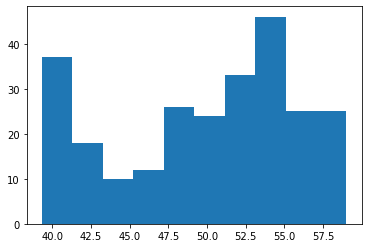

In [ ]:
n, bins, patches = plt.hist(opti_table['mean_abs_unweighted'])

In [ ]:
import scipy.stats as stats

var_of_interest = 'mean_abs_unweighted'
#var_of_interest = 'mean_abs_weighted'
group_var = 'input_var'


#res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]
#               )
#print(group_var, ":", res.pvalue)

group_var = 'normalize'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'add_duration'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'min_dist'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'spread'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'n_components'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]],
                      )
print(group_var, ":", res.pvalue)

normalize : 9.513481539037348e-08
add_duration : 0.005060015397775733
min_dist : 0.591373415366617
spread : 0.8758756944298706
n_components : 1.459600845327066e-08


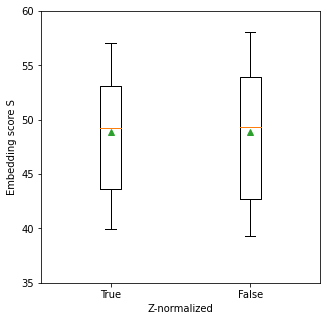

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'normalize'
data = [opti_table[var_of_interest][opti_table[group_var] == normalize_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  normalize_list[1]]]


ax.boxplot(data,
           labels= normalize_list,
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")

plt.show()

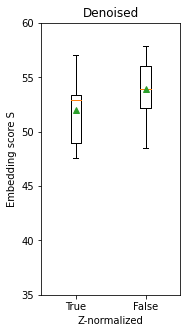

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'normalize'

subset_denoised = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_MFCCs', 'denoised_MFCCs'])]
subset_not_denoised = opti_table[opti_table.input_var.isin(['stretched_spectrograms', 'spectrograms', 'stretched_MFCCs', 'MFCCs'])]

var_of_interest = 'mean_abs_unweighted'
data = [subset_denoised[var_of_interest][subset_denoised[group_var] == True],
        subset_denoised[var_of_interest][subset_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")
plt.title('Denoised')

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-2.8262677142626735, pvalue=0.006330190345859534)

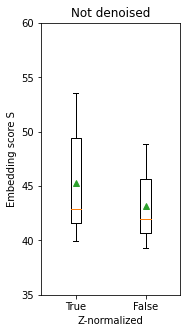

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

data = [subset_not_denoised[var_of_interest][subset_not_denoised[group_var] == True],
        subset_not_denoised[var_of_interest][subset_not_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")
plt.title('Not denoised')

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=2.177948486109653, pvalue=0.033222535528126027)

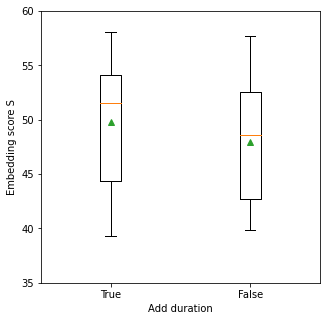

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'
data = [opti_table[var_of_interest][opti_table[group_var] == True],
        opti_table[var_of_interest][opti_table[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")

plt.show()

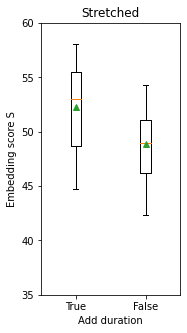

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_stretched[var_of_interest][subset_stretched[group_var] == True],
        subset_stretched[var_of_interest][subset_stretched[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
plt.title('Stretched')

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=3.858889702813935, pvalue=0.00025074281258583497)

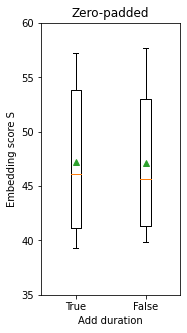

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_padded[var_of_interest][subset_padded[group_var] == True],
        subset_padded[var_of_interest][subset_padded[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
plt.title('Zero-padded')

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=0.07120224825636724, pvalue=0.9434398306213136)

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-2.369666833704848, pvalue=0.018467928312696894)

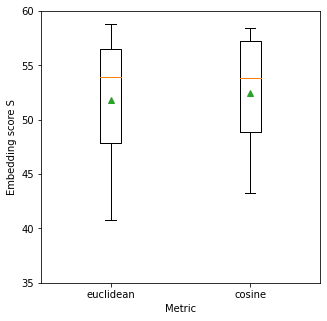

In [ ]:
# Effect of UMAP distance metric
# Need to filter because I tested the angular only on min_dist 0.1, spread 1, n_components 10


fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

dat1=opti_table_all.loc[(opti_table_all['metric'] == 'euclidean') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat1 = dat1[var_of_interest]

dat2 = opti_table_all.loc[(opti_table_all['metric'] == 'cosine') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat2 = dat2[var_of_interest]         

data = [dat1,dat2]


ax.boxplot(data,
           labels= ['euclidean', 'cosine'],
           showmeans= True)
plt.ylim([35,60])
plt.xlabel("Metric")
plt.ylabel("Embedding score S")

plt.show()

In [ ]:
stats.ttest_ind(dat1,dat2)

Ttest_indResult(statistic=-0.4628033985310598, pvalue=0.6451255959842207)

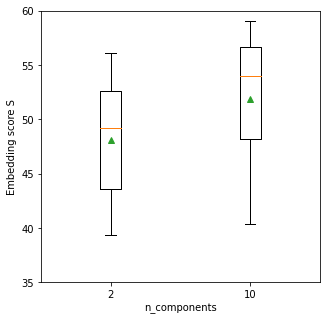

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'n_components'
data = [opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]]]


ax.boxplot(data,
           labels= [n_components_list[0], n_components_list[1]],
           showmeans= True)
plt.ylim([35,60])
plt.xlabel("n_components")
plt.ylabel("Embedding score S")

plt.show()

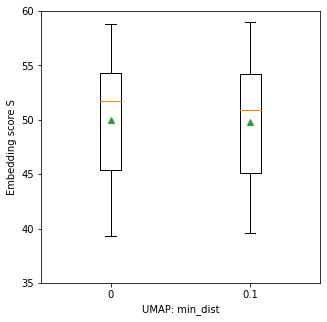

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'min_dist'
data = [opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]]]


ax.boxplot(data,
           labels= min_dists,
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("UMAP: min_dist")
plt.ylabel("Embedding score S")

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=0.21589428980669206, pvalue=0.8292434204910737)

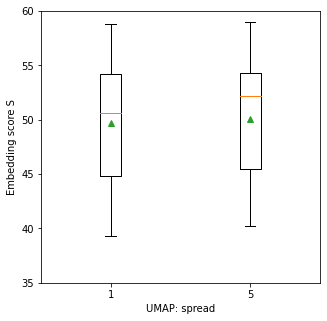

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'spread'
data = [opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]]]


ax.boxplot(data,
           labels= spreads,
           showmeans= True)

plt.ylim([35,60])
plt.xlabel("UMAP: spread")
plt.ylabel("Embedding score S")

plt.show()

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-0.6175368320909537, pvalue=0.5374339255323255)

In [ ]:
input_vars

['mfccs']

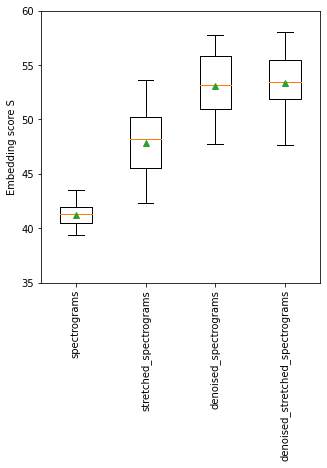

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set
group_var = 'input_var'
data = [opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[3]]]#,
        #opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
        #opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
        #opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
        #opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars[0:4],
           showmeans= True)
plt.ylim([35,60])

plt.xlabel("")
plt.ylabel("Embedding score S")
plt.xticks(rotation=90)

plt.show()

In [ ]:
opti_sorted = opti_table.sort_values(by=['mean_abs_unweighted'], ascending=False)
#opti_sorted.loc[opti_sorted['input_var']=='stretched_mfccs',:]

In [ ]:
opti_sorted.iloc[0:40,]

,k,min_dist,spread,metric,n_components,input_var,add_duration,normalize,mean_log_unweighted,mean_log_weighted,mean_abs_unweighted,mean_abs_weighted
271,10,0.1,1,cosine,10,denoised_stretched_spectrograms,True,False,2.367999,1.838033,58.022834,69.438111
127,10,0.1,5,euclidean,10,denoised_stretched_spectrograms,True,False,2.352718,1.828762,57.857811,69.021783
262,10,0.1,1,cosine,10,denoised_spectrograms,False,False,2.359895,1.827096,57.727671,69.033998
119,10,0.0,5,euclidean,10,denoised_stretched_spectrograms,True,False,2.342084,1.825394,57.678041,68.921010
123,10,0.1,1,euclidean,10,denoised_stretched_spectrograms,True,False,2.348049,1.819857,57.590797,68.592223
115,10,0.0,1,euclidean,10,denoised_stretched_spectrograms,True,False,2.325934,1.817461,57.210728,68.613599
263,10,0.1,1,cosine,10,denoised_spectrograms,True,False,2.337456,1.820222,57.210020,68.881311
111,10,0.1,5,euclidean,10,denoised_stretched_spectrograms,True,True,2.314733,1.810292,57.032396,68.316368
103,10,0.0,5,euclidean,10,denoised_stretched_spectrograms,True,True,2.303175,1.807171,56.870714,68.232899
59,10,0.1,1,euclidean,10,denoised_spectrograms,True,False,2.293680,1.802357,56.570061,68.216612


In [ ]:
opti_table.columns

Index(['k', 'min_dist', 'spread', 'metric', 'n_components', 'input_var',
       'add_duration', 'normalize', 'mean_log_unweighted', 'mean_log_weighted',
       'mean_abs_unweighted', 'mean_abs_weighted'],
      dtype='object')

## How many dimensions?

Evaluate, how many dimensions are best for the embedding.

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_balanced'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding[:,0:10])

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
umap_df = df

In [ ]:
k=5

In [ ]:
dims_tab = np.zeros((9,1))
labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))

for n_dims in range(1,10):
  # Get nearest neighbors
  indices, distances = get_knn(k,embedding[:,0:n_dims])
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)
  
  mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  print(mean_metric)
  dims_tab[n_dims-1,:] = mean_metric

33.027311353858515
46.7170671637607
51.837897968612076
54.44231753542194
54.57799767590778
54.31700457291821
54.2593115599625
54.44622601682609
54.43522296758655


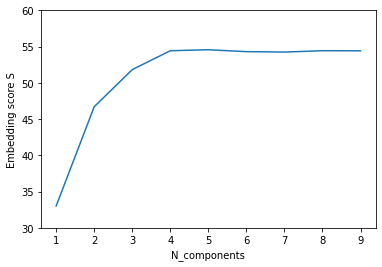

In [ ]:
x = np.arange(1,10,1)
y = dims_tab[:9,0]
plt.plot(x,y)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.ylim(30,60)
#plt.show()
plt.savefig(FIGURES+'n_dims.png')

# Graph from embedding evaluation

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

In [ ]:
stats_tab_norm

,agg,al,cc,ld,mo,sn,soc
agg,2.915297,-2.198610,-0.741042,-3.832458,-3.438827,-3.178117,0.938794
al,-2.488117,2.694885,-1.393385,-0.425301,0.231946,-2.628294,-2.344447
cc,-1.134384,-1.599836,1.778445,-1.313229,-2.744026,-3.301376,-0.585595
ld,-4.832458,-0.617946,-1.382770,3.323115,1.733423,-4.162607,-0.495405
mo,-3.207501,-0.031669,-2.275121,1.658848,2.434532,-2.739996,-2.170141
sn,-2.672882,-2.564164,-3.183271,-4.162607,-2.970609,1.691681,-2.994569
soc,0.793644,-2.429695,-0.371912,-0.530738,-2.248615,-2.968097,1.771306


In [ ]:
np.power(2,stats_tab_norm)

,agg,al,cc,ld,mo,sn,soc
agg,7.543829,0.217847,0.598307,0.070196,0.092217,0.110482,1.916925
al,0.178239,6.475023,0.380671,0.744684,1.174418,0.161735,0.196902
cc,0.455529,0.329915,3.430562,0.402419,0.149268,0.101435,0.666374
ld,0.035098,0.651598,0.383482,10.008229,3.325157,0.055838,0.709362
mo,0.108254,0.978288,0.206595,3.157643,5.405890,0.149685,0.222189
sn,0.156813,0.169087,0.110088,0.055838,0.127573,3.230328,0.125471
soc,1.733448,0.185605,0.772758,0.692200,0.210426,0.127795,3.413629


In [ ]:
import graphviz
import networkx as nx
import string

!wget https://anaconda.org/anaconda/pygraphviz/1.3/download/linux-64/pygraphviz-1.3-py36h14c3975_1.tar.bz2
!tar xvjf pygraphviz-1.3-py36h14c3975_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import pygraphviz

In [ ]:
sim_mat = np.asarray(stats_tab_norm).copy()
#sim_mat = np.asarray(np.power(2,stats_tab_norm)).copy()
for i in range(sim_mat.shape[0]):
  for j in range(i,sim_mat.shape[0]):
    if i!=j:
      #sim_mat[i,j] = gmean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[i,j] = np.mean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[j,i] = sim_mat[i,j]
    else:
      sim_mat[i,j] = 0

In [ ]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6
0,0.000000,0.197050,0.522060,0.049636,0.099914,0.131625,1.822879
1,0.197050,0.000000,0.354385,0.696588,1.071876,0.165370,0.191170
2,0.522060,0.354385,0.000000,0.392836,0.175608,0.105673,0.717597
3,0.049636,0.696588,0.392836,0.000000,3.240318,0.055838,0.700729
4,0.099914,1.071876,0.175608,3.240318,0.000000,0.138187,0.216228
5,0.131625,0.165370,0.105673,0.055838,0.138187,0.000000,0.126628
6,1.822879,0.191170,0.717597,0.700729,0.216228,0.126628,0.000000


In [ ]:
#sim_mat = np.log2(sim_mat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log2



In [ ]:
for i in range(sim_mat.shape[0]):
  sim_mat[i,i] = 0

In [ ]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6
0,0.000000,-2.343363,-0.937713,-4.332458,-3.323164,-2.925500,0.866219
1,-2.343363,0.000000,-1.496610,-0.521623,0.100139,-2.596229,-2.387071
2,-0.937713,-1.496610,0.000000,-1.347999,-2.509574,-3.242324,-0.478753
3,-4.332458,-0.521623,-1.347999,0.000000,1.696135,-4.162607,-0.513072
4,-3.323164,0.100139,-2.509574,1.696135,0.000000,-2.855303,-2.209378
5,-2.925500,-2.596229,-3.242324,-4.162607,-2.855303,0.000000,-2.981333
6,0.866219,-2.387071,-0.478753,-0.513072,-2.209378,-2.981333,0.000000


In [ ]:
dist_mat = sim_mat*(-1)
dist_mat = np.interp(dist_mat, (dist_mat.min(), dist_mat.max()), (1, 10))

In [ ]:
for i in range(dist_mat.shape[0]):
  dist_mat[i,i] = 0

In [ ]:
pd.DataFrame(dist_mat, columns=calltypes, index=calltypes)

,agg,al,cc,ld,mo,sn,soc
agg,0.000000,7.030509,4.932034,10.000000,8.493239,7.899572,2.238970
al,7.030509,0.000000,5.766404,4.310859,3.382640,7.408008,7.095759
cc,4.932034,5.766404,0.000000,5.544544,7.278642,8.372554,4.246860
ld,10.000000,4.310859,5.544544,0.000000,1.000000,9.746431,4.298093
mo,8.493239,3.382640,7.278642,1.000000,0.000000,7.794776,6.830484
sn,7.899572,7.408008,8.372554,9.746431,7.794776,0.000000,7.982925
soc,2.238970,7.095759,4.246860,4.298093,6.830484,7.982925,0.000000


In [ ]:
dt = [('len', float)]
A = dist_mat

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),calltypes))) 

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="#bec1d4", style="filled", shape='circle', fontsize='20')
G.edge_attr.update(color="blue", width="2.0")

G.draw(FIGURES+'simgraph.png', format='png', prog='neato')

# Make interactive plot df

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n


In [ ]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)

In [ ]:
embedding.head(3)

,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
0,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
2,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
embedding.columns = ['UMAP'+str(col) for col in embedding.columns]
embedding.columns

Index(['UMAP0', 'UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7',
       'UMAP8', 'UMAP9', 'UMAPindex_id'],
      dtype='object')

In [ ]:
for col in embedding.columns:
  spec_df[col] = embedding[col].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600


In [ ]:
# Add metadata

In [ ]:
sorted(list(set(spec_df['indv'])))
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match ? * ! %
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
        meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "is actually ", ind_code)
    else:
      print(ind, "not in dyemarks")

HMB is actually  VCVM001
HRT not in dyemarks
HTB is actually  VHMF001
LT is actually  VHMF031
PET not in dyemarks
RT is actually  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Dominant'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }
for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'NA', 
                         'Dye mark': 'NA', 
                         'Sex': 'NA', 
                         'Status':'NA'}

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in spec_df['indv']]
spec_df['Sex'] = sex
status = [meerkat_dict[ind]['Status'] for ind in spec_df['indv']]
spec_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filename = [os.path.basename(wav_path) for wav_path in spec_df['original_wav']]
spec_df['filename'] = filename

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(5)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id,Sex,status,filename
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1601,ALARM,1:12:15.427,0:00.134,decimal,Cue,NaN,y,4335.427,0.134,4335.561,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM

In [ ]:
filename = [x[:-4] for x in filename]

In [ ]:
filename_1 = [x[0:30] for x in filename]
filename_2 = [x[30:60] if len(x)>60 else x[30:] for x in filename]
filename_3 = [x[60:] if len(x)>60 else '' for x in filename]

In [ ]:
spec_df['fn_1'] = filename_1
spec_df['fn_2'] = filename_2
spec_df['fn_3'] = filename_3

In [ ]:
plot_df = spec_df[['Name', 'call_lable', 'indv', 'raw_audio', 
                   'denoised_spectrograms','duration_s', 'samplerate_hz', 
                  'UMAP0', 'UMAP1', 'UMAP2', 'index_id', 'Sex', 'status', 'Start', 'fn_1',
                   'fn_2', 'fn_3']]

In [ ]:
plot_df = plot_df.drop(columns=['denoised_spectrograms'])

In [ ]:
plot_df.head(3)

,Name,call_lable,indv,raw_audio,duration_s,samplerate_hz,UMAP0,UMAP1,UMAP2,index_id,Sex,status,Start,fn_1,fn_2,fn_3,HDBSCAN
1598,ALARM,al,HMB,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...",0.178,8000,5.299764,6.417554,4.202350,1598,M,Dominant,1:10:56.215,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1599,ALARM,al,HMB,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...",0.317,8000,6.663779,7.219666,3.152430,1599,M,Dominant,1:12:04.643,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,-1
1600,ALARM,al,HMB,"[0.005859375, 0.005859375, 0.0078125, 0.005859...",0.192,8000,6.665429,6.820063,4.278993,1600,M,Dominant,1:12:15.132,HM_HMB_R11_AUDIO_file_4_(2017_,08_23-06_44_59)_ASWMUX221163,,5


In [ ]:
os.system('pip install hdbscan')
import hdbscan

In [ ]:
cluster_df = np.asarray(embedding.iloc[:,0:10])
cluster_df.shape

(6687, 10)

In [ ]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #20, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6687
Number of classes:  13
Unassigned:  3167 ( 0.4736055032151937 )


In [ ]:
#plot_df['HDBSCAN'] = HDBSCAN.labels_

plot_df.to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta')

In [ ]:
plot_df.iloc[:3000,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
plot_df.iloc[3000:,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

In [ ]:
p1 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
p2 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

res = pd.concat([p1,p2])
res.shape

(6687, 17)

# Nearest Neighbor Visualization

In [ ]:
import random
import scipy

In [ ]:
os.listdir(DATA)

In [ ]:
# choose dataset
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']

# choose embdding
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)
embedding = embedding.iloc[:,0:10]

In [ ]:
knn=5
n_examples=3
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
names = spec_df.Name.values

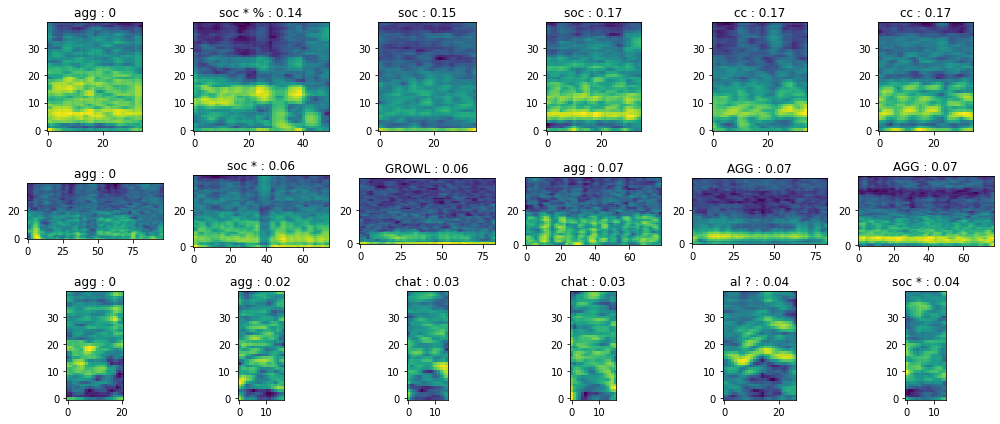

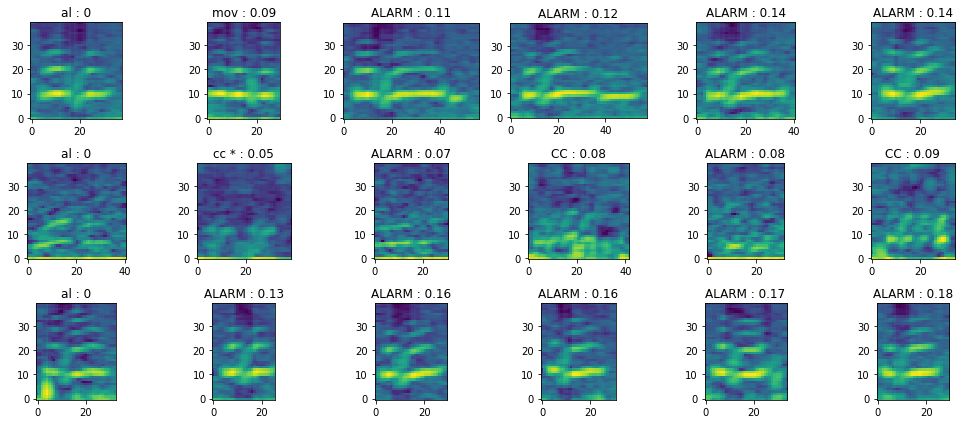

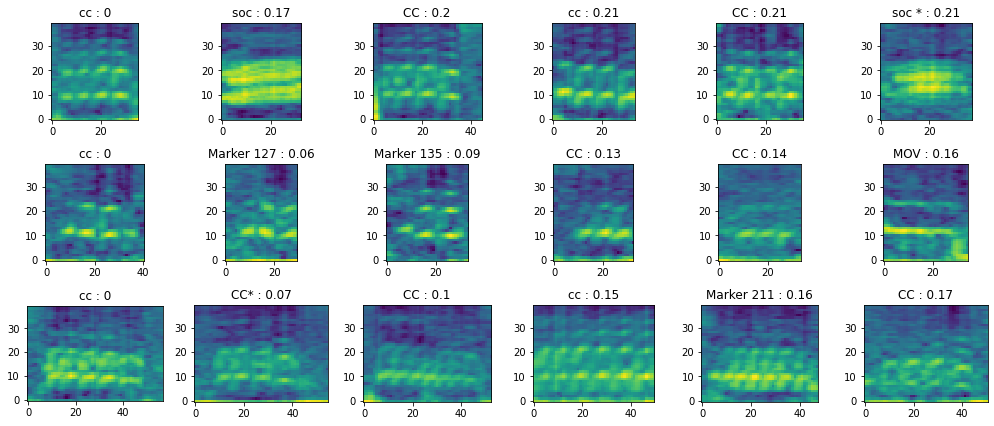

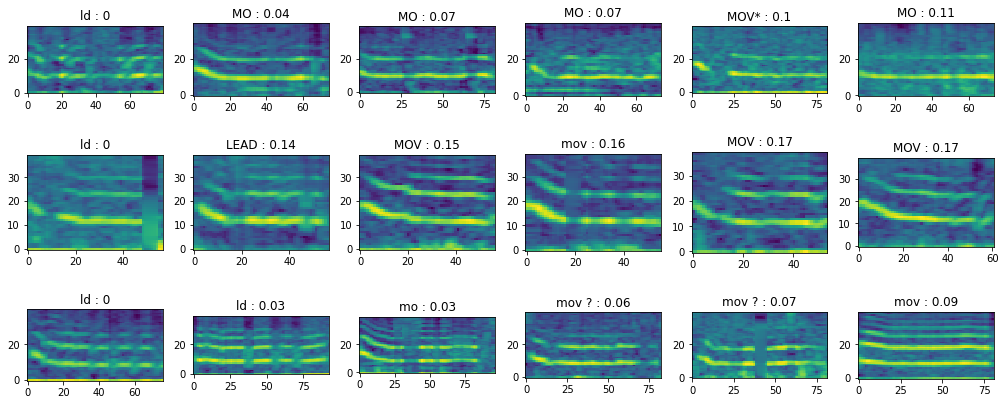

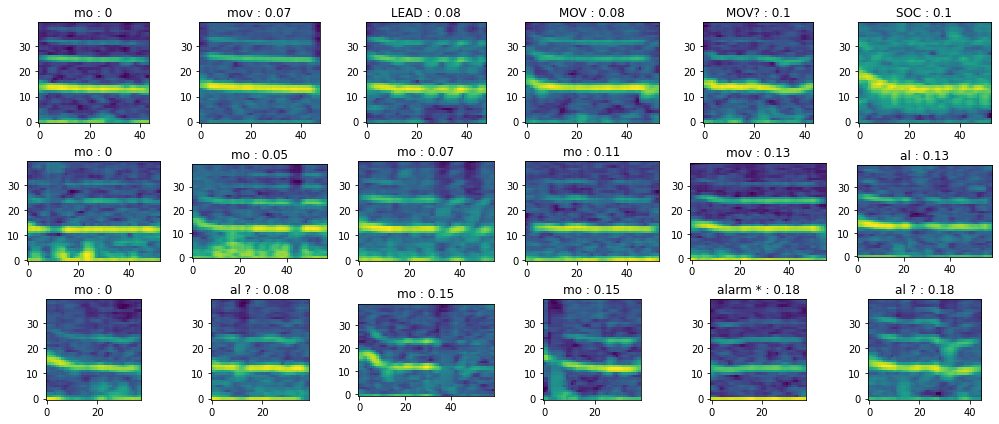

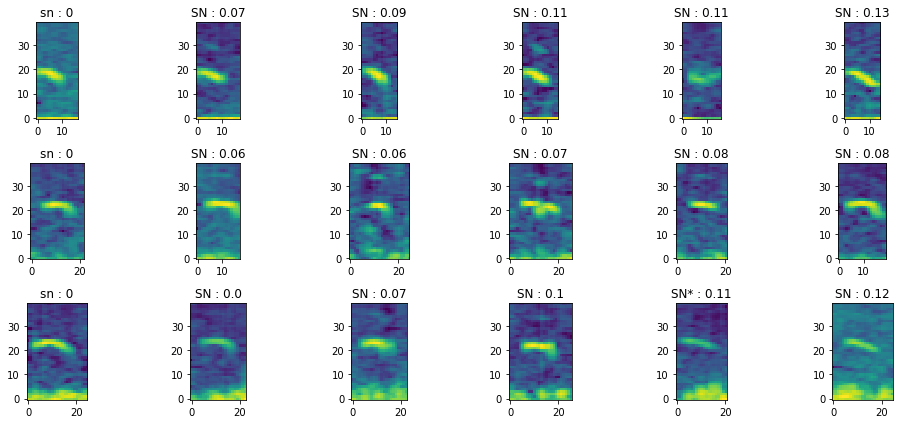

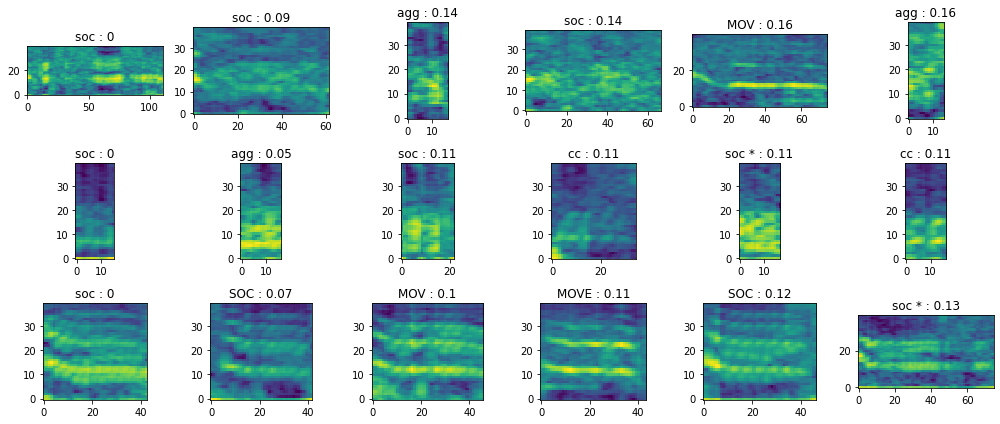

In [ ]:
# make plots

for calltype in calltypes:

  fig = plt.figure(figsize=(14,6))
  fig_name = 'NN_Viz_'+calltype
  k=1
  call_indices = np.asarray(np.where(labels==calltype))[0]

  # randomly choose 3
  example_indices = random.sample(list(call_indices), n_examples)

  for i,ind in enumerate(example_indices):
    img_of_interest = spec_df.iloc[ind,:].denoised_spectrograms
    embedding_of_interest = embedding.iloc[ind,:]
    plt.subplot(n_examples, knn+1, k)
    #librosa.display.specshow(np.transpose(spec))
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
    plt.title(calltype+' : 0')
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = names[neighbor]
      neighbor_embedding = embedding.iloc[neighbor,:]
      dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
      neighbor_img = spec_df.iloc[neighbor,:].denoised_spectrograms
      plt.subplot(n_examples, knn+1, k)
      #librosa.display.specshow(np.transpose(spec))
      plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
      plt.title(neighbor_label+' : '+str(round(dist_to_original, 2)))
      k=k+1
        
  plt.tight_layout() 
  plt.savefig(FIGURES+fig_name)

Files for Frants 1

In [ ]:
# Extract calls for Frants!

 Cexample_calls = spec_df.sample(frac=0.003, replace=False, random_state=1)
example_calls_min.shape
example_calls_min.to_pickle(DATA+'example_calls')
for i in range(example_calls_min.shape[0]):
  y = example_calls_min.iloc[i].raw_audio
  sr = example_calls_min.iloc[i].samplerate_hz
  filename = str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable+'.wav'

  librosa.output.write_wav(DATA+'frants/'+filename, y, sr, norm=False)

i=4
str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable

# Files for Frants 2

In [ ]:
files = os.listdir(DATA+'frants/')

In [ ]:
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))

In [ ]:
files = os.listdir(DATA+'frants/')
fileIDs = [int(x.split('_')[0]) for x in files]

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [ ]:
for fileID, filename in zip(fileIDs, files):
  sr = df.loc[df['index_id']==fileID,'samplerate_hz'].values[0]
  dur = df.loc[df['index_id']==fileID,'duration_s'].values[0]
  offset = df.loc[df['index_id']==fileID,'start_s'].values[0]
  wav_loc = df.loc[df['index_id']==fileID,'original_wav'].values[0]

  # add padding
  dur = dur+0.2
  offset = offset-0.1

  y = get_audio(wav_loc, offset, dur)
  librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, y, sr, norm=False)


In [ ]:
fileID

15931

In [ ]:

sr = spec_df.loc[spec_df['index_id']==fileID,'samplerate_hz'].values[0]
dur = spec_df.loc[spec_df['index_id']==fileID,'duration_s'].values[0]
offset = spec_df.loc[spec_df['index_id']==fileID,'start_s'].values[0]
wav_loc = spec_df.loc[spec_df['index_id']==fileID,'original_wav'].values[0]

# add padding
dur = dur+0.2
offset = offset-0.1

y = get_audio(wav_loc, offset, dur)
librosa.output.write_wav(DATA+'frants/padded_'+filename, y, sr, norm=False)


8019


In [ ]:
spec_df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAPindex_id,Sex,status,filename
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n,5.299764,6.417554,4.202350,7.906916,5.890747,5.762173,7.925637,2.581645,3.845777,2.846862,1598,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n,6.663779,7.219666,3.152430,7.098815,5.258693,6.454947,8.047126,2.527444,4.023995,2.729822,1599,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n,6.665429,6.820063,4.278993,6.828559,4.940083,5.939328,8.093526,3.022829,4.242816,2.590861,1600,M,Dominant,HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
